# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [48]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import pysal as ps
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import statsmodels.api as sm
import shapely
import seaborn as sns
from matplotlib import colors

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
shape_path = "ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum() / (2.788 * 10 ** 7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Census Tract boundaries colored by boroughs

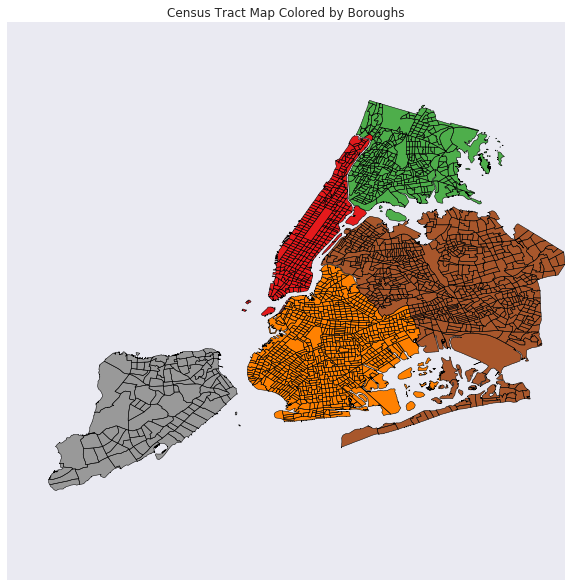

In [49]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column = 'BoroCode',alpha = 1,linewidth=0.5,ax = ax)
plt.title("Census Tract Map Colored by Boroughs")

### Figure 1. Census Tracts of New York City Boroughs
#### Boroughs are represented by color

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data = DataFrame.from_csv("ACS_CT2010.csv")
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

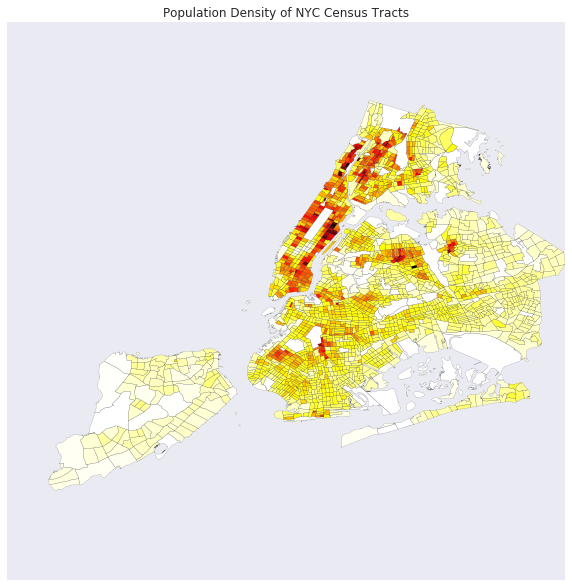

In [50]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column = 'SE_T002_002',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Population Density of NYC Census Tracts")

### Figure 2. Population Density of New York City by Census Tract
#### The most dense census tracts are located in Eastern Manhattan and the Bronx 

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly = DataFrame.from_csv("CitiBike_monthly_byStation.csv")
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Analysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


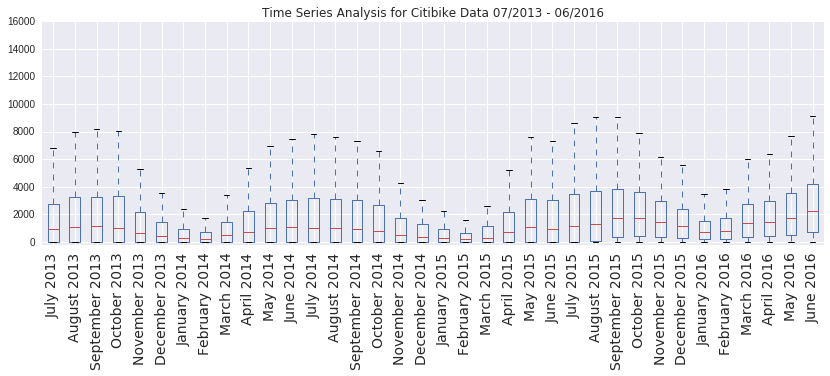

In [51]:
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(figsize = (14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize = (15,7),ax = ax,rot = 90);
ax.set_ylim([-200,16000])
plt.title('Time Series Analysis for Citibike Data 07/2013 - 06/2016')

### Figure 3. Time Series Analysis of Citibike Data for the Months of July 2014 Through June 2016
#### The results show a period trend in Citibike ridership increasing during the summer months 

#### Seasonal Decomposition

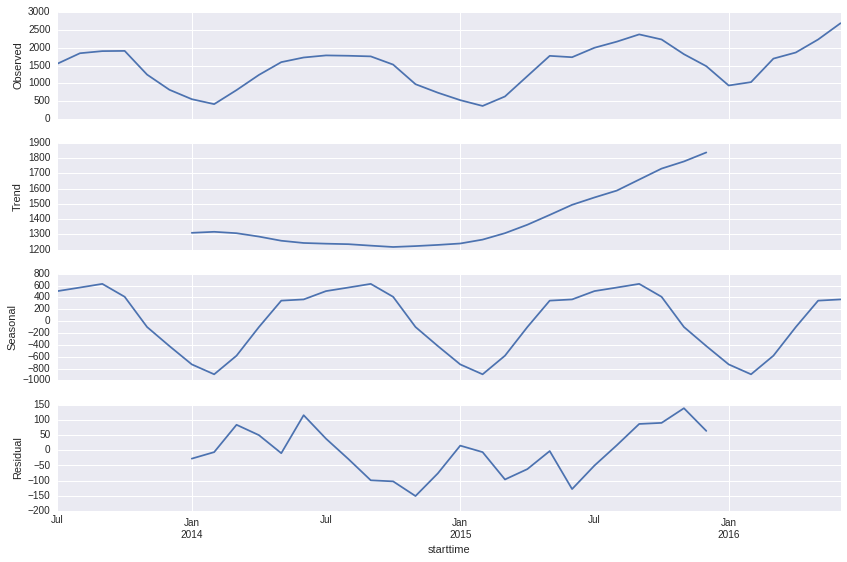

In [52]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace = True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize'] = (12,8)
resplot = res.plot()

### Figure 4. Seasonal Decomposition by Citibike Monthly Average
#### The results further show the change of ridership from summer months and winter months

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [12]:
station_id = DataFrame.from_csv("Station_id.csv")
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [13]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [14]:
a = []
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i + 1) * 100. / len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100.


In [15]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [16]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve'] = df_bike_monthly.sum()

In [17]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044


### Add the monthly average rides to the CT shapefile 

In [18]:
temp = station_id[['MonthlyAve']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


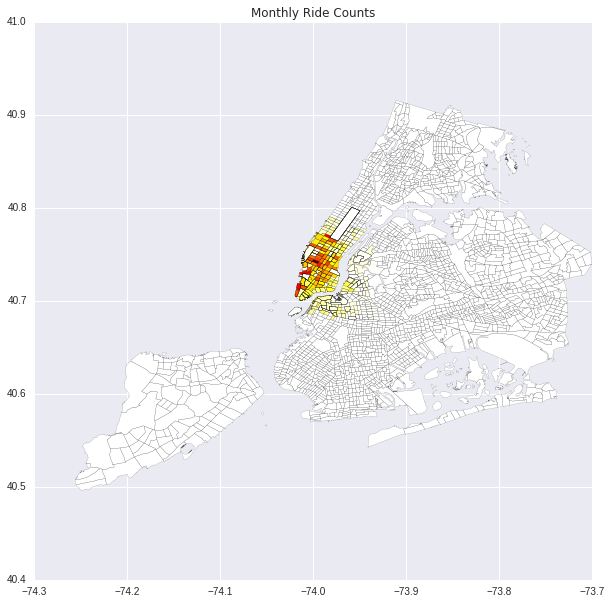

In [53]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column = 'MonthlyAve',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Monthly Ride Counts")

### Figure 5. Average Monthly Ride Counts by Census Tract
#### Ridership is concentrated in Midtown and Downtown Manhattan with some rideship in Brooklyn. The outer boroughs do not have Citibike locations for riders to access

### Removing the CTs that are out of zoom boundries

In [20]:
ct_shape_MonthlyAve_Zoom = (ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x > -74.1 and c.x < -73.92 and c.y > 40.65 and c.y < 40.8)])

In [21]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

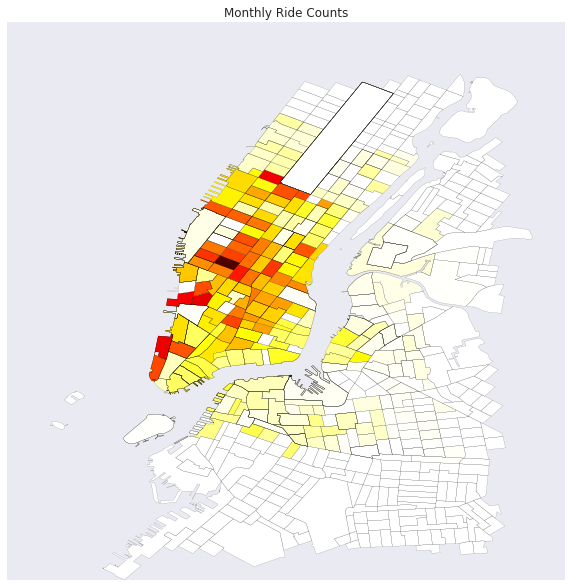

In [54]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column = 'MonthlyAve',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Monthly Ride Counts")

### Figure 6. Average Monthly Ride Counts by Census Tract
#### This map shows only the census tracts where there is Citibike ridership data

### Export Shapefile CTs in the CitiBike Zone

In [23]:
path = "ct_shape_MonthlyAve_Zoom.shp"
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [25]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [26]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [27]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [28]:
Wmatrix, ids = qW_CT.full()

In [29]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [30]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [31]:
MonthlyRide = ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag = ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [32]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k = 10)
MonthlyRideLagQ10

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80

#### Map the monthly rides lag

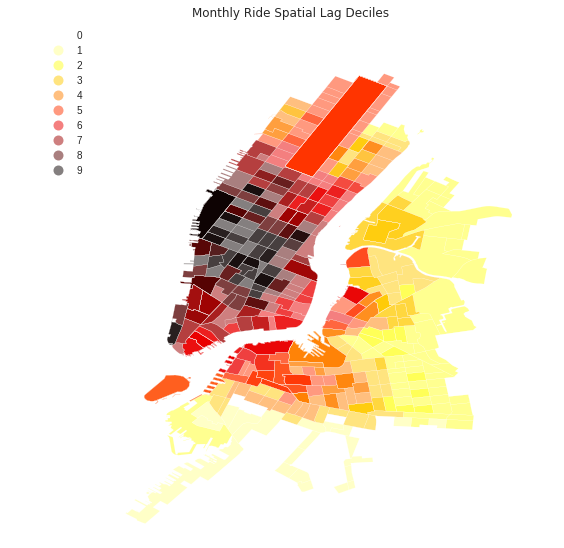

In [55]:
f, ax = plt.subplots(figsize = (9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl = MonthlyRideLagQ10.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap = 'hot_r', linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")


### Figure 7. Similarity of Neighbors by 10 Quantiles

## Global  Spatial Autocorrelation

In [34]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948467, 12557.637062387894)

### Moran Scatterplot

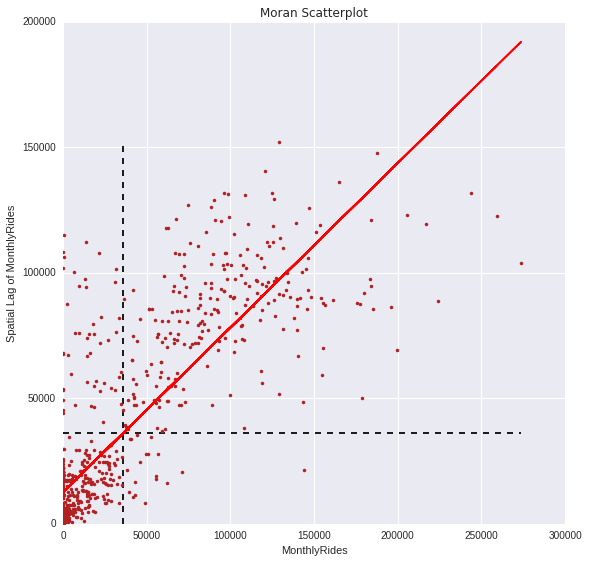

In [56]:
f, ax = plt.subplots(1, figsize = (9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color = 'firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle = '--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b * MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Figure 8. Moran Scatter Plot of  Monthly Ride Values
#### The scatter plot shows the majority of values fall within the quadrant of low values surronded by low values and than the quadrant for high values surronded by high values, both of which represent positive spatial autocorrelation

### Moran's I

In [36]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [37]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.65579332908409083, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [38]:
I_MonthlyRide.sim[0:10]

array([ 0.01715696,  0.03577731, -0.00129496,  0.00897572,  0.02468152,
        0.01950128,  0.00467328,  0.01417568,  0.00337942, -0.0211813 ])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [39]:
plt.rcParams['figure.figsize'] = (14,3)

(-0.7, 0.7)

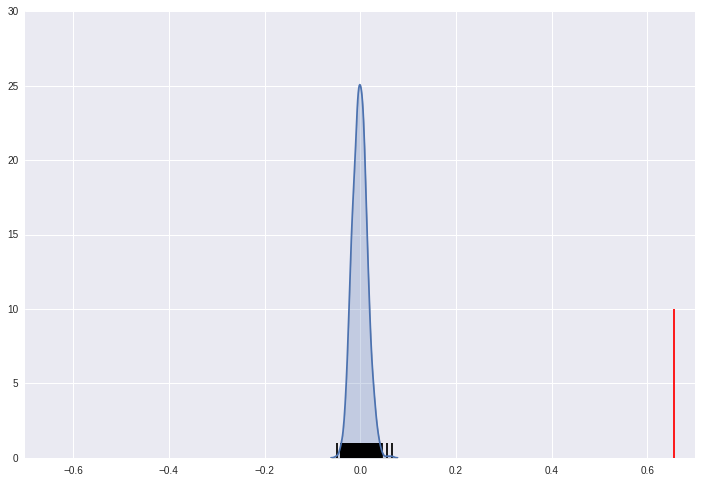

In [57]:
sns.kdeplot(I_MonthlyRide.sim, shade = True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

### Figure 9. KDEplot for the Monthly Ridership 
#### The red vertical line shows the observed value

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

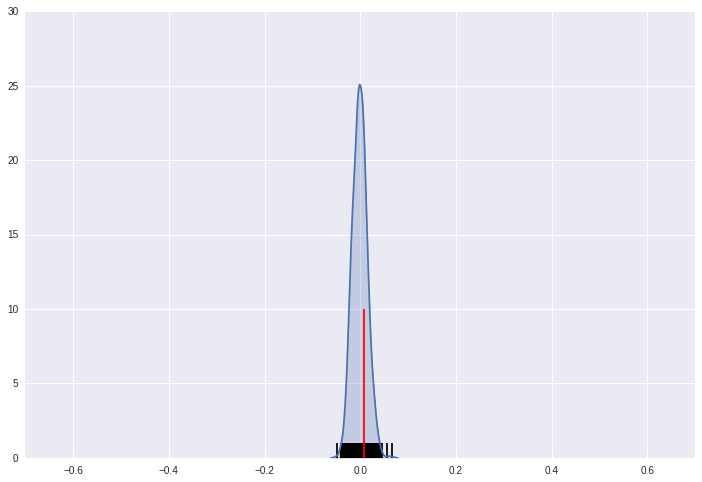

In [58]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

### Figure 10. KDEplot for Monthly Ridership if I Statistic Were Close to Expect Value

## Local  Spatial Autocorrelation

In [42]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [43]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.176,  0.4  ,  0.407,  0.443]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [44]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

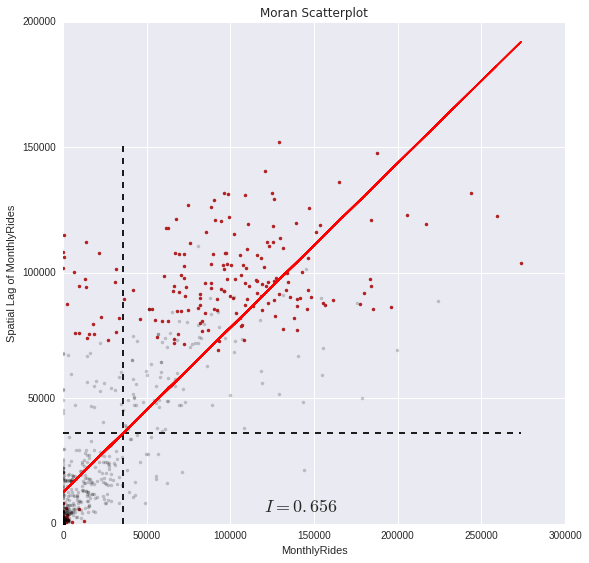

In [59]:
f, ax = plt.subplots(figsize = (9, 9))
plt.plot(sigs, W_sigs, '.', color = 'firebrick')
plt.plot(insigs, W_insigs, '.k', alpha = .2)
plt.text(s = '$I = %.3f$' % I_MonthlyRide.I, x = 120000, y = 5000, fontsize = 18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b * MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')


### Figure 11. Local Indicators of Spatial Autocorrelation Shows Positive Spatial Autocorrelation

### Hot and Cold spots 

In [46]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q == 1 * sig
coldspots = LMo_MonthlyRide.q == 3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 192
Number of Coldspots: 234


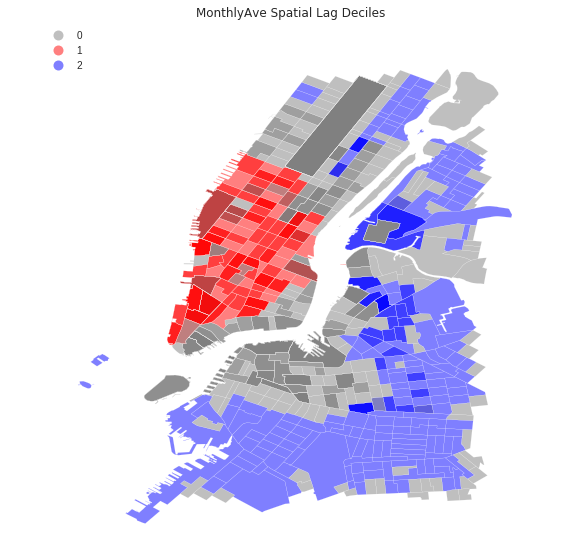

In [60]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl = hotcold).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")

### Figure 12.  Hot and Cold Spot Monthly Average of Census Tracts
#### The hot spots in Manhattan show that Citibike riders in that area are riding and their neighbors are also riding while the cold spots in Brooklyn and Queens show that Citibike riders in those areas are not riding and their neighbors are also not riding. Both the hot and cold spots represent a positive spatial autocorrelation